### ELE075 - Sistemas Nebulosos
**Aluna:** Thais Menegaldi <br>


# Atvidade Prática 1 - Agrupamento Nebuloso

In [ ]:
# !pip install imageio

In [1]:
import os
import random
import imageio
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams.update({'font.size': 12})

## `get_image`

Netsa função, primeiramente, cria-se uma lista contendo os nomes das 11 figuras fornecidas para que seja executada a Segmentação de Imagens por Região utilizando o *Fuzzy C-Means*. 
Após isso é feita a leitura da imagem escolhida, por meio do parâmetro `idx`, que poderá ser redimensionada ou não, de acordo com o parâmetro `resize_image`. De posse da figura escolhida, é feito seu pré-processamento utilizando a função **`image_pre_processing`**.

In [2]:
def get_image(idx, resize_image = True):
    """
    Each index corresponds to an image, as folows:
        0 - photo001.jpg
        1 - photo002.jpg
        2 - photo003.jpg
        3 - photo004.jpg
        4 - photo005.jpg
        5 - photo006.jpg
        6 - photo007.jpg
        7 - photo008.jpg
        8 - photo009.jpg
        9 - photo010.jpg
        10 - photo011.png
        
    Args:
        idx: (int) index of an image
        resize_image: (bool) used to define whether the image should be compressed or not
    Returns:
        X: (numpy.ndarray) matrix containing the horizontally concatenated RGB components of the input image
        picture: (numpy.ndarray) image array
        name_fig: (str) image name
    """
    
    images_list = []
    
    for i in range(1,10):
        images_list.append(f'photo00{i}.jpg')
        
    images_list.append('photo010.jpg')
    images_list.append('photo011.png')
    
    image = images_list[idx]
    picture = imageio.imread(f'./ImagensTeste/{image}')
    
    if resize_image:
        short_pic = Image.fromarray(np.uint8(picture))
        width, height = short_pic.size
        new_height = 100
        new_width = (new_height * width)/height
        short_pic = short_pic.resize((int(new_width), int(new_height)), Image.ANTIALIAS)
        picture = np.array(short_pic.copy())
        
    plt.imshow(picture)
    plt.axis('off')
    plt.show()
    
    X = image_pre_processing(picture)
    name_fig = images_list[idx]
    
    return X, picture, name_fig

## `image_pre_processing`

Esta função extrai as componentes RGB da imgagem escolhida e as concatena em uma única matriz que será utilizada como entrada para o algoritmo de agrupamento. 

In [3]:
def image_pre_processing(pic):
    """
    Takes the RGB components of the image and concatenates them into a matrix.
    
    Args:
        pic: (numpy.ndarray) image array
    Returns:
        X: (numpy.ndarray) matrix containing the horizontally concatenated RGB components of the input image
    """
    image = np.rollaxis(pic, 2, 0)
    print('Image shape:', image.shape)
    
    R = image[0].flatten().astype('float64')
    G = image[1].flatten().astype('float64')
    B = image[2].flatten().astype('float64')

    X = np.vstack((R, G, B)).T
    print('Input matrix shape:', X.shape)
    
    return X

## `get_dataset`

A função a seguir faz a leitura dos dados de FCM_dataset, dataset fornecido para que seja feita a validação do algoritmo *Fuzzy C Means* implementado, e retorna uma matriz contendo esse conjunto de dados.

In [4]:
def get_dataset():
    """
    Reads the FCM_dataset.
    
    Returns:
        X: (numpy.ndarray) matrix containing the fcm_dataset
    """
    file_path = os.path.abspath('./fcm_dataset.mat')

    fcm_dataset = scipy.io.loadmat(file_path)
    X = pd.DataFrame(fcm_dataset['x'], columns = ['x1', 'x2'])
       
    fig, ax = plt.subplots()
    ax.scatter(x = X['x1'], y = X['x2'], s=20)
    ax.grid(True)
    plt.show()
    
    X = X.to_numpy()
    
    return X

## Fuzzy C-Means

Definição dos parâmetros que serão utilizados pelo algoritmo de agrupamento

In [5]:
m = 2

# Number of clusters
K = 4

# Convergence precision
eps = 1e-3

## `initialize_random_matrix`

Esta função faz a inicialiação aleatória da matriz de pertinências $U$, cujas dimensões são $n x K$, de modo que a soma dos elementos em cada linha seja igual a 1:

## $$\sum_{k=1}^{K} \mu_{i,k} = 1, \forall i = 1, ..., n$$

In [6]:
def initialize_random_matrix(n, K):
    """
    Initializes the membership matrix randomly, so that the sum of the elements of each line is equal to 1.
    
    Returns:
        matrix: (numpy.ndarray) membership matrix U
    """
    matrix = np.random.uniform(low = 0, high = 1.0, size = n*K).reshape((n, K))
    matrix = matrix/np.sum(matrix, axis = 1)[:, np.newaxis]
    
    return matrix

## `calculate_centroid`

Em `calculate_centroid` calcula-se os centroides de cada um dos clusters $k \in K$. Este cáculo é feito da seguinte maneira:

# $$ \vec{c}_k = \dfrac{\sum_{i=1}^{n} \mu_{i,k}^{m}\vec{x}_i}{\sum_{i=1}^{n} \mu_{i,k}^{m}}$$

In [7]:
def calculate_centroid(X, membership_matrix):
    """
    Calculates the centroides of each cluster 
    
    Args:
        X: (numpy.ndarray) input data
        membership_matrix: (numpy.ndarray) membership matrix U
    Returns:
        C: (numpy.ndarray) clusters centroids
        
    """
    w = membership_matrix**m
    sum_w = np.sum(w, axis = 0)[:, np.newaxis]
    C = np.dot(w.T, X)/sum_w
        
    return C

## `calculate_membership`

Nesta função é feita a atualização dos pesos $\mu_{i,k}$ da matriz de pertinências $U$ para todas as $n$ amostras. Ess atualização é feita tal que:

### $$u_{ij} = \dfrac{\left(\dfrac{1}{dist(\vec{x}_i, \vec{c}_s)}\right)^{1/(m-1)}}{\sum_{s=1}^{K}\left(\dfrac{1}{dist(\vec{x}_i, \vec{c}_s)}\right)^{1/(m-1)}}$$

In [8]:
def calculate_membership(C, X, U, m):
    """
    Updates the membership matrix U
    
    Args:
        C: (numpy.ndarray) clusters centroids
        X: (numpy.ndarray) input data
        U: (numpy.ndarray) membership matrix U
        m: (int)
    Returns:
        U: (numpy.ndarray) updated membership matrix U
    """
    d = np.zeros((C.shape[0],1))
    
    for i in range(X.shape[0]):
        xi = X[i,:]
        for j in range(C.shape[0]):
            d[j] = (1/np.linalg.norm(xi - C[j]))**(1/(m - 1))
            
        U[i] = (d/np.sum(d)).T
        
    return U  

## `fuzzy_c_means`

Finalmente, esta função executa a rotina de clusterização do algoritmo *Fuzzy C-Means*. O critério de parada utilizado foi a verificação de que não há mais alteração nos centroides dos $K$ clusters. Essa averiguação é feita calculando-se a diferença entre os centroides atuais $C$ e os centroides da iteração anterior $C_{old}$. Em virtude desse cálculo, foi adicionado o parâmetro $eps$ para que seja possível a convergência do algoritmo, uma vez que, devido à precisão da representação numérica computacional, a diferença entre $C$ e $C_{old}$ jamais seria igual a 0.

In [9]:
def fuzzy_c_means(X, K, eps):
    """
    Fuzzy C-Means clustering routine
    
    Args:
        K: (int) number of clusters
        X: (numpy.ndarray) input data
        eps: (float) convergence precision
    Returns:
        C: (numpy.ndarray) clusters centroids
        plot_df: (pandas.DataFrame) pandas.DataFrame with cluster assignments for each sample
        K_list: (list) list of clusters assigned to each sample
    """
    print('\nClustering...\n')
    n = X.shape[0]
    
    U_matrix = initialize_random_matrix(n, K)
    C = calculate_centroid(X, U_matrix)
    stop = False
    iterations = 0


    while stop == False:
        C_old = C.copy()
        U_matrix = calculate_membership(C, X, U_matrix, m)
        C = calculate_centroid(X, U_matrix)

        stop = np.all((C - C_old) < eps)
        iterations += 1

    print('Total number of iterations:', iterations)
    K_list = np.argmax(U_matrix,axis = 1)
    plot_df = pd.concat((pd.DataFrame(X), pd.DataFrame(K_list)), axis = 1)
    
    return C, plot_df, K_list

## `plot_image_result`

Nesta função é feito o plot resultante da segmentação da imagem, de maneira que cada pixel da figura será representado pela cor correspondente ao cluster ao qual ele pertence.

In [10]:
def plot_image_result(plot_df, K, C, pic, name_fig):
    """
    Plot the result of image clustering.
    
    Agrs:
        plot_df: (pandas.DataFrame) pandas.DataFrame with cluster assignments for each sample
        C: (numpy.ndarray) clusters centroids
        K: (int) number of clusters
        pic: (numpy.ndarray) image array
    """
    plot_df.columns = ['R', 'G', 'B', 'K']
    X_ck = X.copy()

    for k in range(K):
        pixels = plot_df.query("K == @k")
        X_ck[pixels.index.values] = C[k]

    X_ck = X_ck.reshape((pic.shape))
    X_ck = X_ck.astype('int')

    plt.imshow(X_ck)
    plt.axis('off')
    plt.savefig(f'res_{name_fig}')
    plt.show()

## `plot_result`

Esta função apresenta graficamente os centroides resultantes de cada cluster sobrepostos ao dados de entrada.

In [11]:
def plot_result(plot_df, C):
    """
    Plot the result of clustering.
    
    Agrs:
        C: (numpy.ndarray) clusters centroids
        plot_df: (pandas.DataFrame) pandas.DataFrame with cluster assignments for each sample
    """
    plot_df.columns = ['x1', 'x2', 'K']

    fig, ax = plt.subplots()
    ax.scatter(x = plot_df['x1'], y = plot_df['x2'], s=20)
    ax.scatter(x = C[:,0], y = C[:,1], s=200, color = ['aquamarine', 'lightgreen', 'pink', 'gold'])
    plt.title('Result of Fuzzy C Means clustering')
    ax.grid(True)
    
    plt.show()

### Execução do *Fuzzy C Means*  para a base de dados FCM_dataset

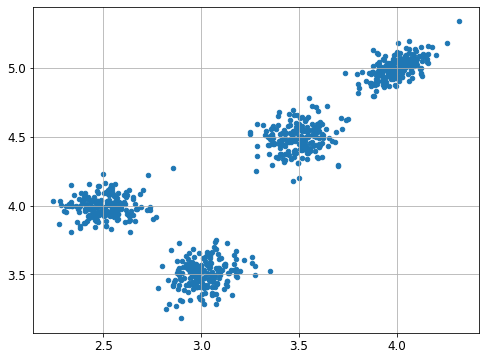


Clustering...

Total number of iterations: 23


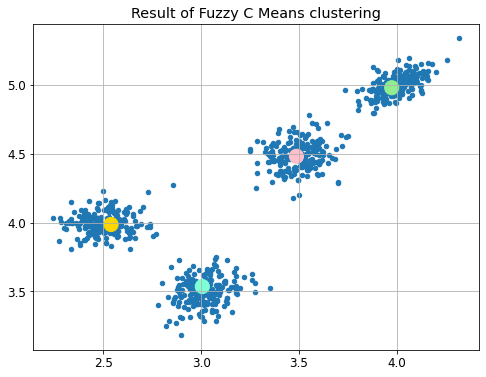

In [12]:
X = get_dataset()
C, plot_df, _ = fuzzy_c_means(X, K, eps)
plot_result(plot_df, C)

### Execução do *Fuzzy C Means*  para segmentação de imagem

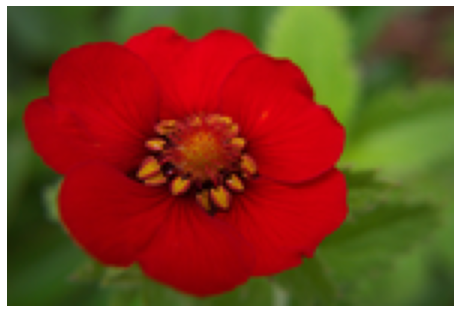

Image shape: (3, 100, 149)
Input matrix shape: (14900, 3)

Clustering...

Total number of iterations: 224


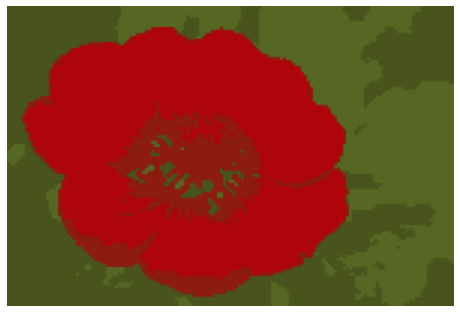

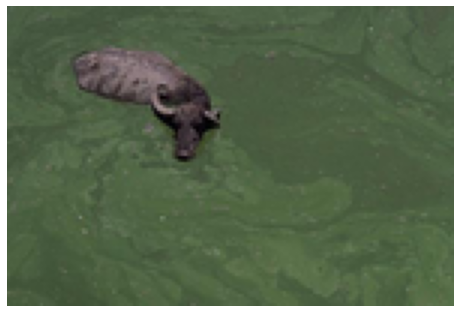

Image shape: (3, 100, 149)
Input matrix shape: (14900, 3)

Clustering...

Total number of iterations: 34


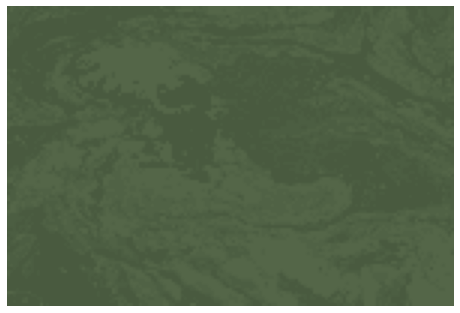

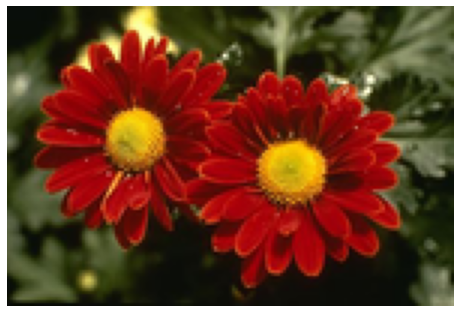

Image shape: (3, 100, 149)
Input matrix shape: (14900, 3)

Clustering...

Total number of iterations: 311


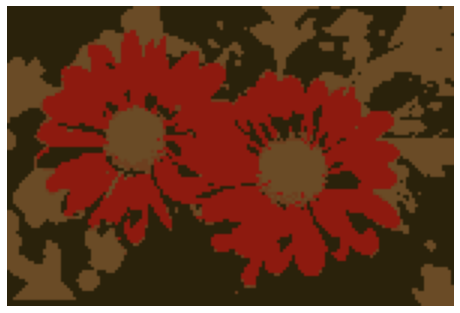

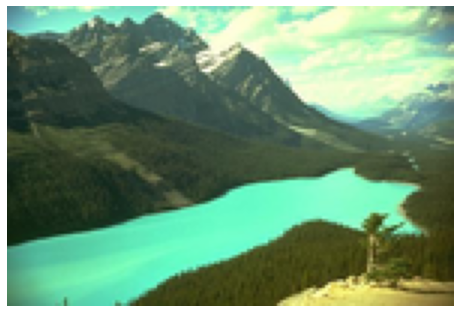

Image shape: (3, 100, 149)
Input matrix shape: (14900, 3)

Clustering...

Total number of iterations: 50


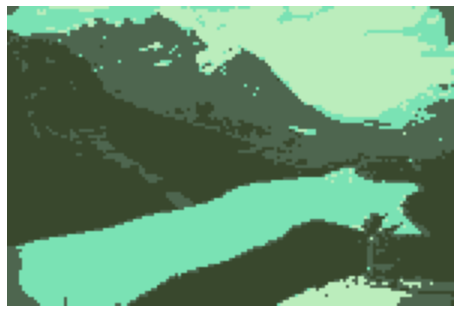

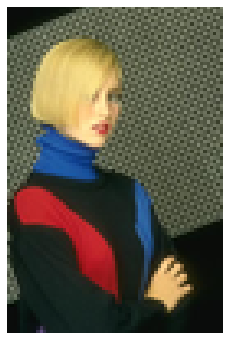

Image shape: (3, 100, 66)
Input matrix shape: (6600, 3)

Clustering...

Total number of iterations: 51


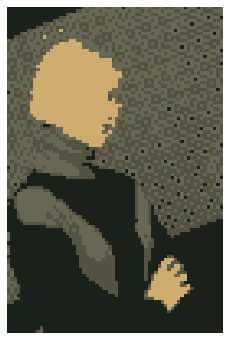

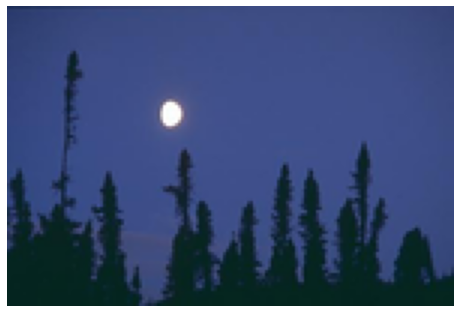

Image shape: (3, 100, 149)
Input matrix shape: (14900, 3)

Clustering...

Total number of iterations: 58


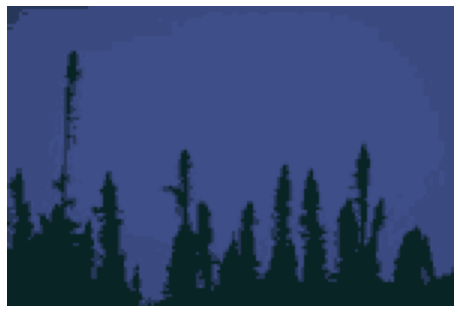

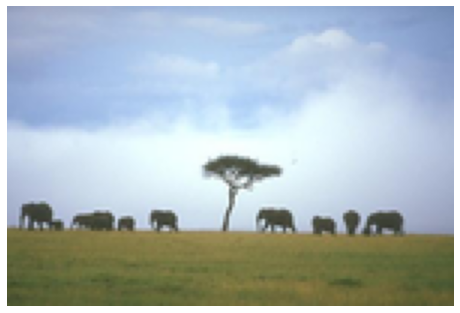

Image shape: (3, 100, 149)
Input matrix shape: (14900, 3)

Clustering...

Total number of iterations: 34


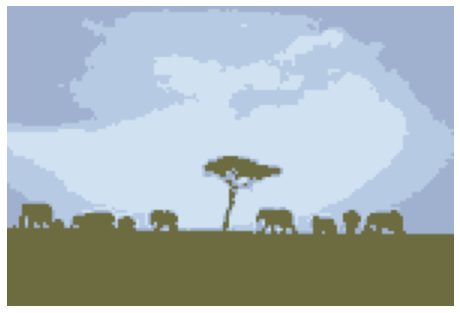

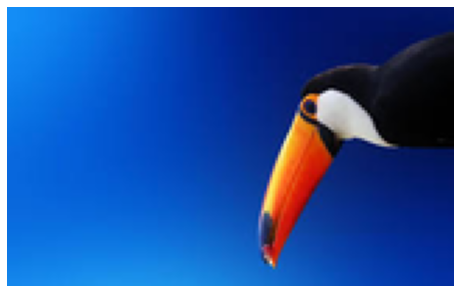

Image shape: (3, 100, 160)
Input matrix shape: (16000, 3)

Clustering...

Total number of iterations: 114


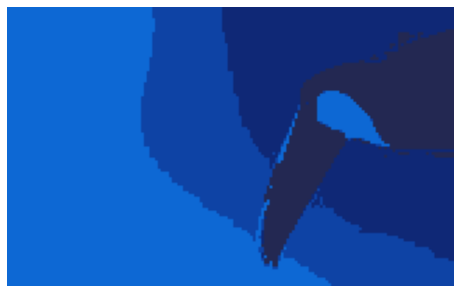

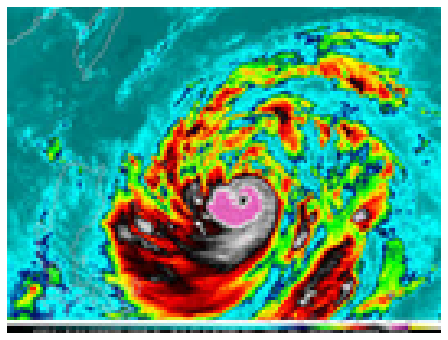

Image shape: (3, 100, 133)
Input matrix shape: (13300, 3)

Clustering...

Total number of iterations: 218


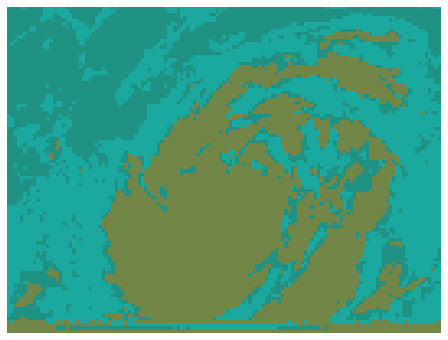

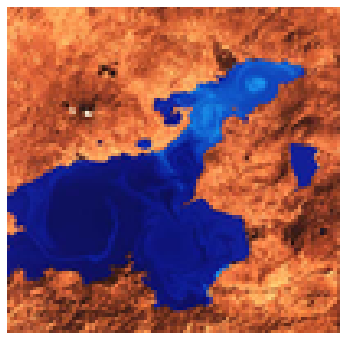

Image shape: (3, 100, 102)
Input matrix shape: (10200, 3)

Clustering...

Total number of iterations: 46


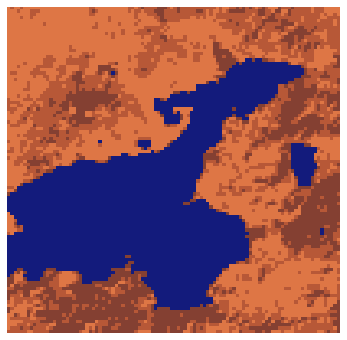

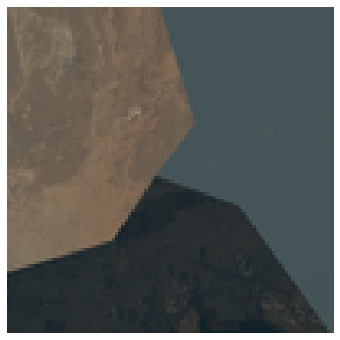

Image shape: (3, 100, 100)
Input matrix shape: (10000, 3)

Clustering...

Total number of iterations: 37


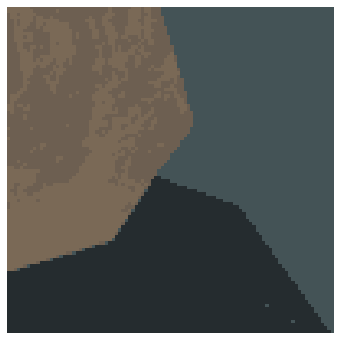

In [14]:
for idx in range(0,11):
    X, pic, name_fig = get_image(idx)
    C, plot_df, _ = fuzzy_c_means(X, K, eps)
    plot_image_result(plot_df, K, C, pic, name_fig)